## PyFolding SI Notebook 4
---

[Authors] ERGM, ARL

---

## Fitting tANK chevron to Three State with fast phase chevron - sharing parameters between models

In this notebook, let's try to fit a complicated model to some example data. Here the idea is to fit two models to two datasets, but share some of the parameters between the two models. In real terms this is difficult to do in most bought fitting software, but we have the full power of a programming language at our disposal.

We can use the GlobalFit object to do exactly what we want. Let's start by getting some nice data digitised from this paper:

```
Structural insights into an equilibrium folding intermediate of an archaeal ankyrin repeat 
protein. Low C, Weininger U, Neumann P, Klepsch M, Lilie H, Stubbs MT, and Balbach J
PNAS (2008) 105: 3779–3784
```
[http://www.pnas.org/cgi/doi/10.1073/pnas.0710657105]

---

Remember, if you are less script/computer orientated, you can simply change the data paths/variables, etc for your proteins and re-run the jupyter notebook ( "Kernal/Restart & Run all" from the menu above).

---

### Data Format

Please see PyFolding SI Notebooks 1 and 2 for the format your data has to be in to enable this type of analysis.

---


In [1]:
# First off let's load pyfolding & pyplot into this ipython notebook
# (pyplot allows us to plot more complex figures of our results):

%matplotlib inline
import pyfolding
from pyfolding import models

# let's use some other libraries also
import matplotlib.pyplot as plt
import numpy as np

<IPython.core.display.Javascript object>

PyFolding: Jupyter autoscrolling has been disabled


In [2]:
# loading the data - The kinetics of each protein is in one .csv as per 
#PyFolding SI Notebooks 1 and 2

pth = "../examples/tANK/"
tANK_all = pyfolding.read_kinetic_data(pth,"ChevronAll.csv")

In [3]:
# let's give this dataset a good name
tANK_all.ID = 'Thermophilic AR protein (tANK)'

---
#### Let's plot the chevron phases:

---

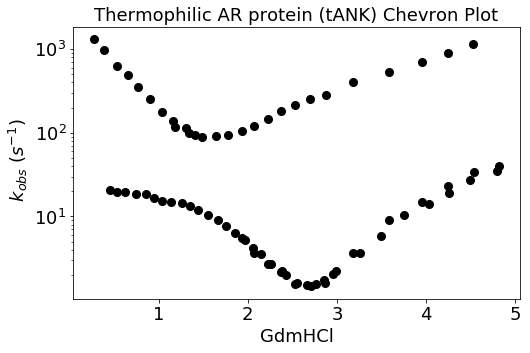

In [4]:
# easy plotting of the entire dataset ...
tANK_all.plot()

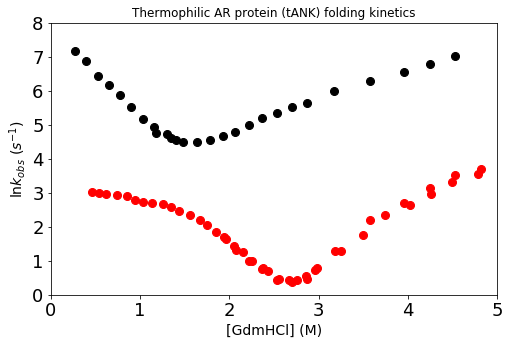

In [5]:
# ...or, custom plotting

k1_x, k1_y = tANK_all.chevron('k1') # defines the slower chevron rates
k2_x, k2_y = tANK_all.chevron('k2') # defines the faster chevron rates

plt.figure(figsize=(8,5))           # makes the figure 8cm by 5cm
plt.plot(k1_x, k1_y, 'ro', markersize=8) # red filled circles, sized '8'
plt.plot(k2_x, k2_y, 'ko', markersize=8) # black filled circles, sized '8'
plt.rc('xtick', labelsize=14)            # fontsize of the x tick labels
plt.rc('ytick', labelsize=14)            # fontsize of the y tick labels
plt.ylim([0, 8])                         # y axis from 0 to 8
plt.xlim([0, 5])                         # x axis from 0 to 5
plt.grid(False)                          # no grid on the graph
plt.xlabel('[GdmHCl] (M)', fontsize=14)  # x axis title with fontsize
plt.ylabel(r'$\ln k_{obs}$ $(s^{-1})$', fontsize=14)  # y axis title with fontsize
plt.title('Thermophilic AR protein (tANK) folding kinetics') # Plot title
plt.show()


---

#### Note that the measurements were performed at $15^\text{o}$C, so we need to adjust the temperature:

---

In [6]:
pyfolding.set_temperature(15.0)

Set temperature to 15.00°C
(NOTE: Careful, this sets the temperature for all subsequent calculations)


---

#### In the paper they decided that their data showed that their protein was folding via a three state mechanism.  So lets try fitting the digitized data to this model - three state chevron with fast phase. To do this, we need to share the parameters like this:

1. Fit a "two-state chevron" model to the fast phase, and share those params with:
2. A "three-state with fast phase" model for the slower phase

First of all lets print the information on each model:

---

In [7]:
models.TwoStateChevron().info()

<IPython.core.display.Math object>

 Two state chevron plot.

	Folding Scheme:
		N <-> D

	Params:
		k obs = rate constant of unfolding or refolding at a particular denaturant concentration
		kf = rate constant of refolding at a particular denaturant concentration
		mf = the gradient of refolding arm of the chevron
		ku = rate constant of unfolding at a a particular denaturant concentration
		mu = the gradient of unfolding arm of the chevron
		x = denaturant concentration (M)

	Notes:
		Jackson SE and Fersht AR.  Folding of chymotrypsin inhibitor 2.
		1. Evidence for a two-state transition.
		Biochemistry (1991) 30(43):10428-10435.
	


In [8]:
models.ThreeStateFastPhaseChevron().info()

<IPython.core.display.Math object>

 Three state chevron with single intermediate.

	Folding Scheme: N <-> I <-> D

	Params:
		k obs = rate constant of unfolding or refolding at a particular denaturant concentration
		kfi = microscopic rate constant for the conversion of folded to intermediate
		kif = microscopic rate constant for the conversion of intermediate to folded
		kiu = microscopic rate constant for the conversion of intermediate to unfolded
		kui = microscopic rate constant for the conversion of unfolded to intermediate
		Kiu = equilibrium constant for the rapid equilibration between intermediate & unfolded
		mfi = m-value associated with the kinetic transition between folded & intermediate
		mif = m-value associated with the kinetic transition between intermediate & folded
		miu = m-value associated with the kinetic transition between intermediate & unfolded
		mui = m-value associated with the kinetic transition between unfolded & intermediate
		x = denaturant concentration (M)

	Reference:
		Parker et al. An 

---

**To fit the data to two equations at once where certain parameters are shared, we need to create a fast phase model, which is essentially a two state chevron, but where the parameters represent the folding and unfolding of the intermediate. We can do this *on-the-fly* by using the template model to create a new **FastPhase** model:**

---

In [9]:
class FastPhase(pyfolding.FitModel):
    """ Fast phase model
    """
    def __init__(self):
        pyfolding.FitModel.__init__(self)
        fit_args = self.fit_func_args
        self.params = tuple( [(fit_args[i],i) for i in xrange(len(fit_args))] )
        self.default_params = np.array([100., 1.3480, 5e-4, 1.])
        self.verified = True


    def fit_func(self, x, kui, mui, kiu, miu):
        k_obs = kui*np.exp(-mui*x) + kiu*np.exp(miu*x)
        return k_obs

    def error_func(self, y):
        return np.log(y)

---

### Setting up a custom Global fit

---

In [10]:
def plot_fig():
    # now that we've fitted the data, plot a figure
    plt.figure(figsize=(8,5))
    plt.plot(k1_x, k1_y, 'ro', markersize=8)
    plt.plot(k2_x, k2_y, 'ko', markersize=8)

    # plot each of the chevrons...
    for r in results:
        plt.plot(r.x_fit, r.y_fit, 'k-', linewidth=2)

    plt.xlim([min(k1_x), max(k1_x)])
    plt.rc('xtick', labelsize=18)    # fontsize of the x tick labels
    plt.rc('ytick', labelsize=18)    # fontsize of the y tick labels
    plt.grid(False)
    plt.xlabel('[GdmHCl] (M)', fontsize=18)
    plt.ylabel(r'$\ln k_{obs}$ $(s^{-1})$', fontsize=18)
    plt.ylim([0, 8])
    plt.show()

In [11]:
# We first need to differentiate the data into the two phases we will fit
k1_x, k1_y = tANK_all.chevron('k1') # defines the slower chevron rates
k2_x, k2_y = tANK_all.chevron('k2') # defines the faster chevron rates

# start by setting up a GlobalFit object
global_fit = pyfolding.GlobalFit()
global_fit.fit_funcs = (models.ThreeStateFastPhaseChevron, FastPhase)
global_fit.x = (k1_x, k2_x) # remember, k1 defines the slower chevron
global_fit.y = (k1_y, k2_y) # & k2 defines are faster chevron
global_fit.ID = ['slow_phase','fast_phase']
global_fit.shared = ['kui', 'mui', 'kiu', 'miu']
global_fit.initialise()


In [12]:
# find out the order of params for p0
print global_fit.params.keys()

['mui', 'miu', 'kui', 'kiu', 'kif_{slow_phase}', 'mif_{slow_phase}', 'kfi_{slow_phase}', 'mfi_{slow_phase}']


In [13]:
# set some reasonable starting parameters for the fit
p0 = np.array([1.7, 0.01, 1860., 2.7, 2652.0, 2.8, 14., 1.])
bounds = ((-5.,-5.,0.,0.,0.,-5.,0.,-5), (5.,5.,1e4,1e4,1e4,5.,1e4,5.))

# run the fit and get the results
_,_ = global_fit.fit(p0=p0, bounds=bounds)
results = global_fit.results


---

**Display the results from the fitting. Note that in the results table, (f) means a free-variable, (s) is shared and (c) is constant.**

---

In [19]:
models.ThreeStateFastPhaseChevron().info()

<IPython.core.display.Math object>

 Three state chevron with single intermediate.

	Folding Scheme: N <-> I <-> D

	Params:
		k obs = rate constant of unfolding or refolding at a particular denaturant concentration
		kfi = microscopic rate constant for the conversion of folded to intermediate
		kif = microscopic rate constant for the conversion of intermediate to folded
		kiu = microscopic rate constant for the conversion of intermediate to unfolded
		kui = microscopic rate constant for the conversion of unfolded to intermediate
		Kiu = equilibrium constant for the rapid equilibration between intermediate & unfolded
		mfi = m-value associated with the kinetic transition between folded & intermediate
		mif = m-value associated with the kinetic transition between intermediate & folded
		miu = m-value associated with the kinetic transition between intermediate & unfolded
		mui = m-value associated with the kinetic transition between unfolded & intermediate
		x = denaturant concentration (M)

	Reference:
		Parker et al. An 

In [14]:
for r in results: 
    r.display()

Fitting results
ID: slow_phase
Model: ThreeStateFastPhaseChevron
Optimiser: pyfolding.GlobalFit and scipy.optimize.curve_fit
Temperature: 15.00°C

(s) kui 2652.18225 ± 54.43026   	 95% CI[2638.45737, 2665.90713]
(s) mui    2.82889 ± 0.02696    	 95% CI[   2.82210,    2.83569]
(s) kiu   14.30673 ± 0.37100    	 95% CI[  14.21318,   14.40028]
(s) miu    0.99906 ± 0.00828    	 95% CI[   0.99698,    1.00115]
(f) kif 1860.56406 ± 63.30515   	 95% CI[1844.60133, 1876.52680]
(f) mif    2.73831 ± 0.01748    	 95% CI[   2.73391,    2.74272]
(f) kfi    0.01057 ± 0.00038    	 95% CI[   0.01047,    0.01066]
(f) mfi    1.76794 ± 0.00936    	 95% CI[   1.76558,    1.77030]
--------------------------------------------------------------------------------
R^2: 0.97224


Fitting results
ID: fast_phase
Model: FastPhase
Optimiser: pyfolding.GlobalFit and scipy.optimize.curve_fit
Temperature: 15.00°C

(s) kui 2652.18225 ± 52.85223   	 95% CI[2638.84956, 2665.51494]
(s) mui    2.82889 ± 0.02618    	 95% CI[ 

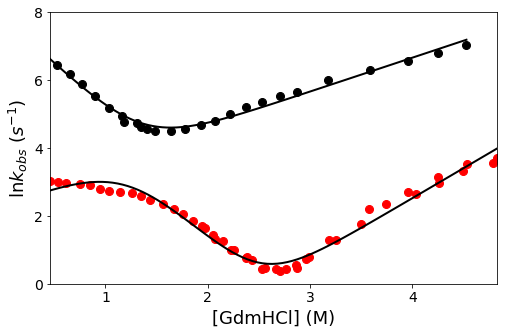

In [15]:
plot_fig()

---

### We can also output this with the  "prettier" graphics showing chevron & equilibrium curves together
(as in PyFolding SI Notebook 1)

---

### 1st  - we need to add the kinetic results to the protein object

---

In [16]:
tANK_all.results = results[0]
tANK_all.components = {'fast': np.exp(results[1].y_fit)}
tANK_all.fit_func = models.ThreeStateFastPhaseChevron

---

### 2nd - lets get the equilibrium data & fit to a three state model

---

Fitting results
ID: tANK_equilmFluorscence
Model: ThreeStateEquilibrium
Optimiser: pyfolding.GlobalFit and scipy.optimize.curve_fit
Temperature: 15.00°C

(f) Y_N   324.75027 ± 0.74190    	 95% CI[ 324.56451,  324.93603]
(f) Y_I   197.11446 ± 3.56063    	 95% CI[ 196.22293,  198.00599]
(f) Y_D    66.56156 ± 0.75910    	 95% CI[  66.37149,   66.75162]
(f) DGni    4.77711 ± 0.21538    	 95% CI[   4.72318,    4.83104]
(f) m_ni    2.96838 ± 0.14905    	 95% CI[   2.93106,    3.00570]
(f) DGid    8.33336 ± 0.44659    	 95% CI[   8.22154,    8.44518]
(f) m_id    3.09530 ± 0.15594    	 95% CI[   3.05626,    3.13435]
--------------------------------------------------------------------------------
R^2: 0.99983




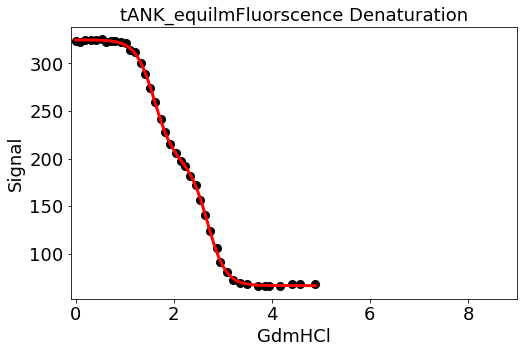

In [17]:
#1st load the data by adding the equilibrium
tank_Equilm = pyfolding.read_equilibrium_data(pth, "tANK_equilmFluorscence.csv")

#then select the fit function and associate it with the data
tank_Equilm.fit_func = models.ThreeStateEquilibrium

# Fit it with parameters (as the defaults ones are not close enough)
tank_Equilm.fit(p0=[350,2,25,18.5,11.6,34,12.6])

# Plot the figure to check
tank_Equilm.plot()


---

### 3rd - lets plot both together & print out to pdf

---

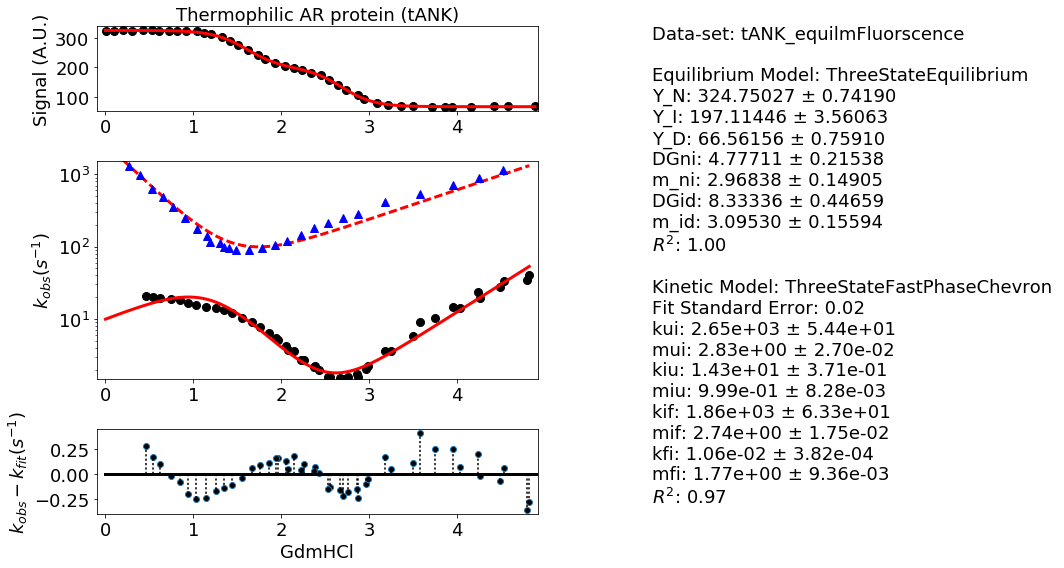

In [18]:
pyfolding.plot_figure(tank_Equilm, tANK_all, display=True)


---

#### End of this Notebook.

---